In [27]:
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from obspy import read
from scipy import signal

import functions

In [28]:
def scale_amplitude(data, rate):
    'Scale amplitude or waveforms'
    
    tmp = np.random.uniform(0, 1)
    if tmp < rate:
        data *= np.random.uniform(1, 3)
    elif tmp < 2 * rate:
        data /= np.random.uniform(1, 3)
    return data

In [29]:
def normalize(data):
    'Normalize waveforms over each event'
        
    max_data = np.max(data, axis=(1, 2), keepdims = True)
    assert(max_data.shape[0] == data.shape[0])
    max_data[max_data == 0] = 1
    data /= max_data              
    return data

In [30]:
def quantize(A, dtype = np.int16):
    'quantize float data in range [-127,127]'
    m = np.max(np.abs(A), axis = (1, 2), keepdims = True)
    factors = np.iinfo(dtype).max / m 
    return (A * factors).astype(dtype = dtype)

In [31]:
def stream_prep(input_Stream, label):
    fsin = input_Stream[0].stats.sampling_rate
    fsout = 40.0
    wlen = 2.0
    alpha = 0.05
    freq = 0.5
    maxshift = 80
    shift_event_r = 0.995
    scale_amplitude_r = 0.3
    dim = int(wlen * fsout)

    input_Stream.detrend(type = "linear")
    input_Stream.taper(alpha)
    input_Stream.filter(type = "highpass", freq = freq)

    data = np.vstack([input_Stream[i].data for i in range(len(input_Stream))])
    window_view = np.lib.stride_tricks.sliding_window_view(data, (3, 200))
    window = window_view.reshape(-1, 3, 200)
    window_list = [arr for arr in window]
    window_resample_list = [signal.resample(arr, dim, axis = 1) for arr in window_list]

    if scale_amplitude_r:
        for i in range(len(window_resample_list)):
            window_resample_list[i] = scale_amplitude(window_resample_list[i], scale_amplitude_r)
            window_resample_list[i] = window_resample_list[i].transpose()

    window_resample = np.stack(window_resample_list)
    window_resample = np.expand_dims(window_resample, axis = -1)

    window_resample = functions.normalize(window_resample)
    window_resample = functions.quantize(window_resample)
    window_resample = window_resample.astype(np.float32)
    window_resample = functions.normalize(window_resample)

    model = torch.load('./model/EarthquakeCNN_finetuned.pth')

    Xall_list = [np.expand_dims(arr, axis = 0) for arr in window_resample]
    softmax = nn.Softmax(dim = 1)
    Y_list = []

    for i in range(len(Xall_list)):
        X = torch.from_numpy(Xall_list[i]).float()
        X = X.permute(0, 3, 1, 2)

        Y = model(X)
        Y = softmax(Y)
        Y = Y.detach().numpy()
        Y_list.append(Y)

    station_name = input_Stream[0].stats.location
    instrument_name = input_Stream[0].stats.station
    station_info = station_name + ' ' + instrument_name + ' '

    # 將你的 ndarray 放入一個 list
    list_of_arrays = Y_list

    # 將所有的 ndarrays 拼接成一個大的 ndarray
    data = np.vstack(list_of_arrays)

    # 生成 x 座標
    x = np.arange(data.shape[0])

    classes = ['P-wave', 'S-wave', 'Noise']

    # 創建圖像和軸的實例
    fig, ax = plt.subplots(figsize = (8, 6))

    # 繪製堆疊區域圖
    ax.stackplot(x, data.T, labels=classes)

    # 在 y=0.33 的位置添加一條水平線
    ax.axhline(y = 1/3, color = 'C3', linestyle = 'dashdot')
    ax.axhline(y = 2/3, color = 'C3', linestyle = 'dashdot')
    # ax.axhline(y = 0.5, color = 'dimgray', linestyle = 'dashdot')

    # 在 data[:, 0] < 0.5 的位置畫上星星
    star_x = x[data[:, 2] < 0.5]
    star_y = data[data[:, 2] < 0.5, 2]
    star_y = 1 - star_y

    if label == 'noise':
        # ax.scatter(star_x, star_y, marker = '*', color = 'yellow')
        pass

    # 添加圖例
    ax.legend()

    # 設定標題
    ax.set_title(station_info + str(input_Stream[0].stats.starttime))
    ax.set_xlabel('Number of Sample')
    ax.set_ylabel('Probability Distribution')

    plt.tight_layout()
    # Save the figure to a file

    if label == 'event':
        plt.savefig('./Result_Finetuing/Single_event_test.pdf')
        input_Stream.plot(color = 'C0', outfile = './Result_Finetuing/Single_event_threechannel.pdf')

    if label == 'noise':
        plt.savefig('./Result_Finetuing/Single_noise_test.pdf')
        input_Stream.plot(color = 'C0', outfile = './Result_Finetuing/Single_noise_threechannel.pdf')

    if label == 'others':
        plt.savefig('./Result_Finetuing/Single_others_test.pdf')
        input_Stream.plot(color = 'C0', outfile = './Result_Finetuing/Single_others_threechannel.pdf')
    else:
        plt.savefig('./Result_Finetuing/Single_' + label + '_test.pdf')
        input_Stream.plot(color = 'C0', outfile = './Result_Finetuing/Single_' + label + '_threechannel.pdf')


    # 顯示圖表
    plt.show()

In [32]:
datadir = './dada_QSIS_test'

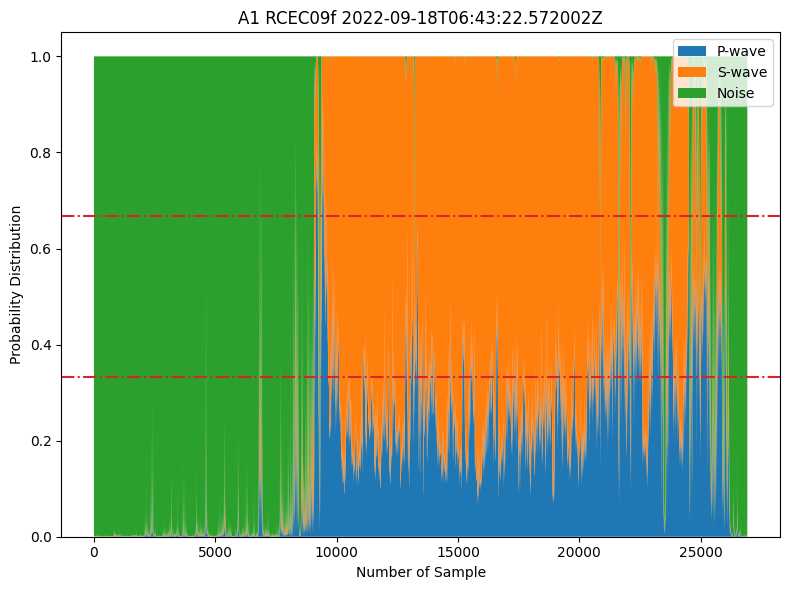

In [33]:
file1 = datadir + '/RCEC.09f.5AF30.TW.A1.HLX.2022.09.18.06.43.22.sac'
file2 = datadir + '/RCEC.09f.5AF30.TW.A1.HLY.2022.09.18.06.43.22.sac'
file3 = datadir + '/RCEC.09f.5AF30.TW.A1.HLZ.2022.09.18.06.43.22.sac'
evaluate_event = read(file1) + read(file2) + read(file3)
stream_prep(evaluate_event, label = 'event')

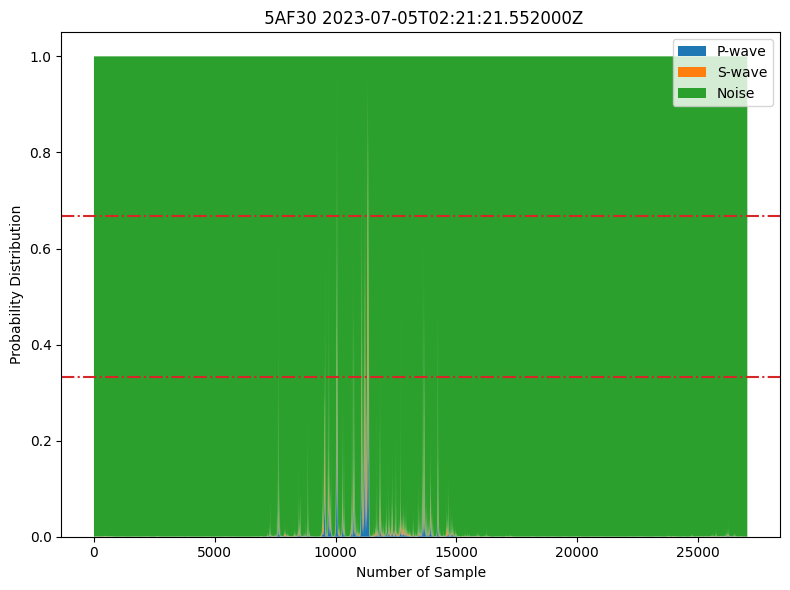

In [34]:
file4 = datadir + '/5AF30.TW..HLX.2023.07.05.02.21.21.sac'
file5 = datadir + '/5AF30.TW..HLY.2023.07.05.02.21.21.sac'
file6 = datadir + '/5AF30.TW..HLZ.2023.07.05.02.21.21.sac'
evaluate_noise = read(file4) + read(file5) + read(file6)
stream_prep(evaluate_noise, label = 'noise')

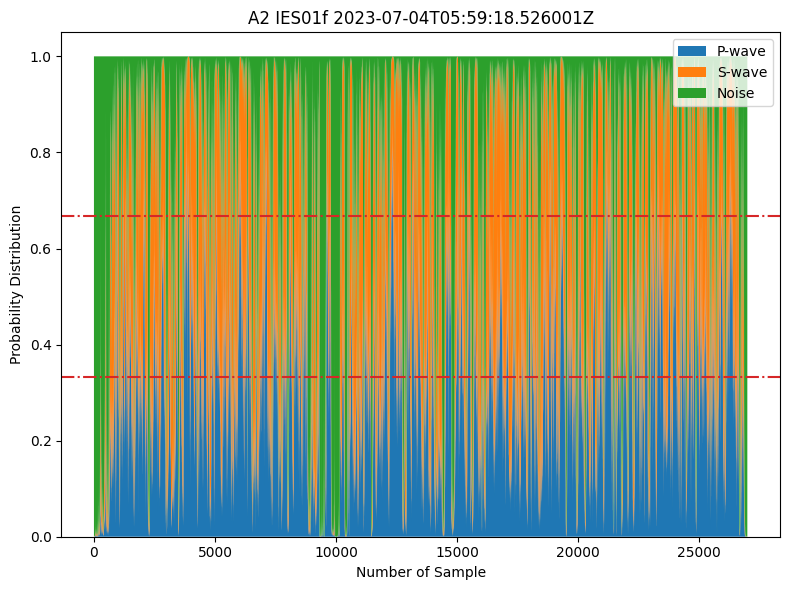

In [35]:
# 2023-07-04 06:02:07(UTC), 24.31°N, 121.78°E, depth: 5km, ML:3.1

file7 = datadir + '/IES.01f.5AE21.TW.A2.HLX.2023.07.04.05.59.18.sac'
file8 = datadir + '/IES.01f.5AE21.TW.A2.HLY.2023.07.04.05.59.18.sac'
file9 = datadir + '/IES.01f.5AE21.TW.A2.HLZ.2023.07.04.05.59.18.sac'

evaluate_noise = read(file7) + read(file8) + read(file9)
stream_prep(evaluate_noise, label = 'others')

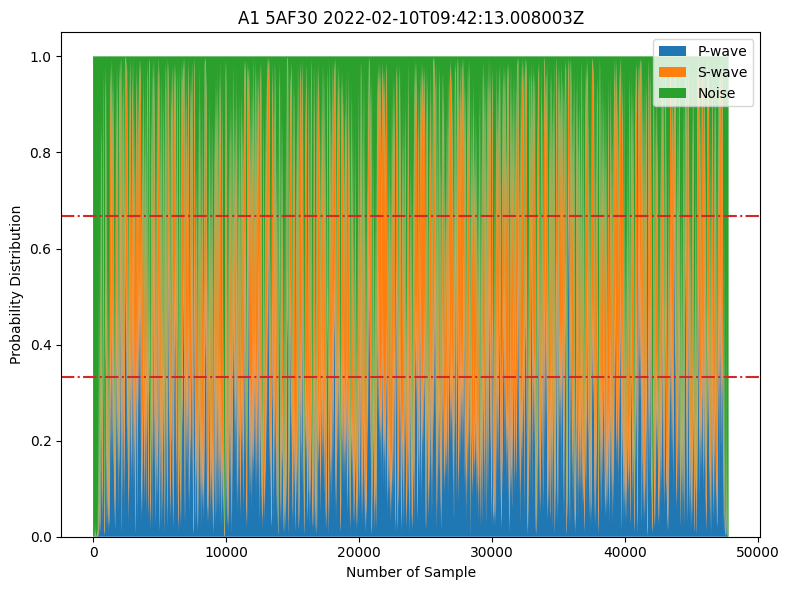

In [36]:
# 2022-02-10 09:44:13(UTC), 24.69°N, 120.99°E, depth: 10km, ML:2.6

file10 = datadir + '/T2_RCEC.09f.5AF30.TW.A1.HLX.2022.02.10.09.44.13.sac'
file11 = datadir + '/T2_RCEC.09f.5AF30.TW.A1.HLY.2022.02.10.09.44.13.sac'
file12 = datadir + '/T2_RCEC.09f.5AF30.TW.A1.HLZ.2022.02.10.09.44.13.sac'
evaluate_noise = read(file10) + read(file11) + read(file12)
stream_prep(evaluate_noise, label = 'unlikely')

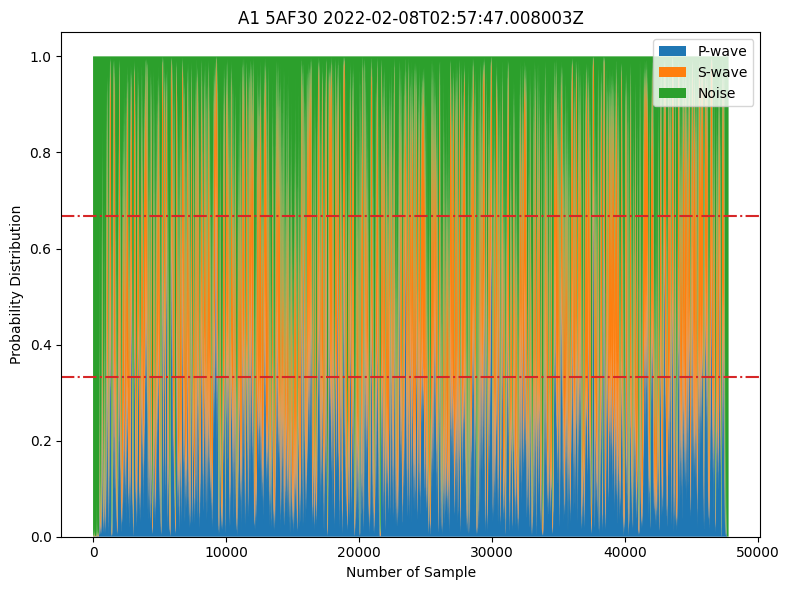

In [37]:
# 2022-02-08 02:59:47(UTC), Depth: 5km, ML3 #

file13 = datadir + '/T3_RCEC.09f.5AF30.TW.A1.HLX.2022.02.08.02.59.47.sac'
file14 = datadir + '/T3_RCEC.09f.5AF30.TW.A1.HLY.2022.02.08.02.59.47.sac'
file15 = datadir + '/T3_RCEC.09f.5AF30.TW.A1.HLZ.2022.02.08.02.59.47.sac'
evaluate_noise = read(file13) + read(file14) + read(file15)
stream_prep(evaluate_noise, label = 'unlikely_2')

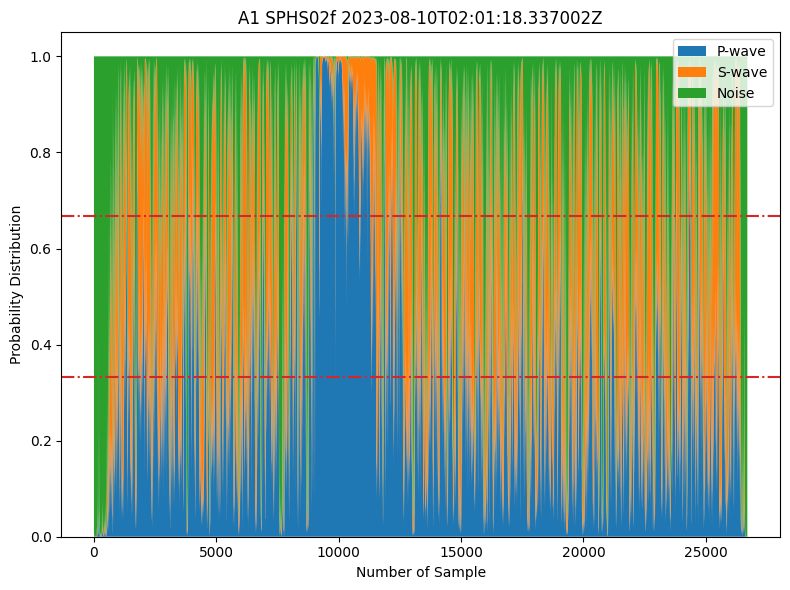

In [38]:
file_SPHS_2f_1 = datadir + '/SPHS.02f.5AE12.TW.A1.HLX.2023.08.10.02.01.18.sac'
file_SPHS_2f_2 = datadir + '/SPHS.02f.5AE12.TW.A1.HLY.2023.08.10.02.01.18.sac'
file_SPHS_2f_3 = datadir + '/SPHS.02f.5AE12.TW.A1.HLZ.2023.08.10.02.01.18.sac'
evaluate_SPHS_2f = read(file_SPHS_2f_1) + read(file_SPHS_2f_2) + read(file_SPHS_2f_3)
stream_prep(evaluate_SPHS_2f, label = 'SPHS_2f')

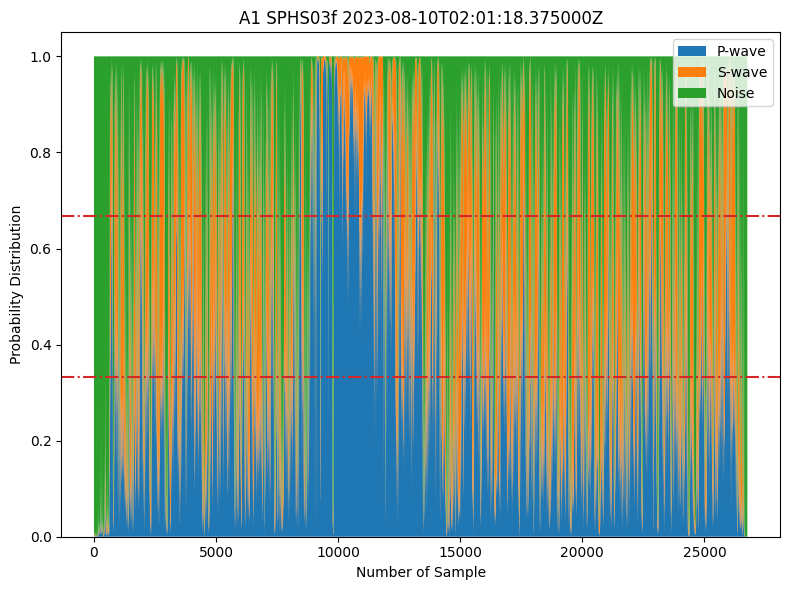

In [39]:
file_SPHS_3f_1 = datadir + '/SPHS.03f.5AF5C.TW.A1.HLX.2023.08.10.02.01.18.sac'
file_SPHS_3f_2 = datadir + '/SPHS.03f.5AF5C.TW.A1.HLY.2023.08.10.02.01.18.sac'
file_SPHS_3f_3 = datadir + '/SPHS.03f.5AF5C.TW.A1.HLZ.2023.08.10.02.01.18.sac'
evaluate_SPHS_3f = read(file_SPHS_3f_1) + read(file_SPHS_3f_2) + read(file_SPHS_3f_3)
stream_prep(evaluate_SPHS_3f, label = 'SPHS_3f')

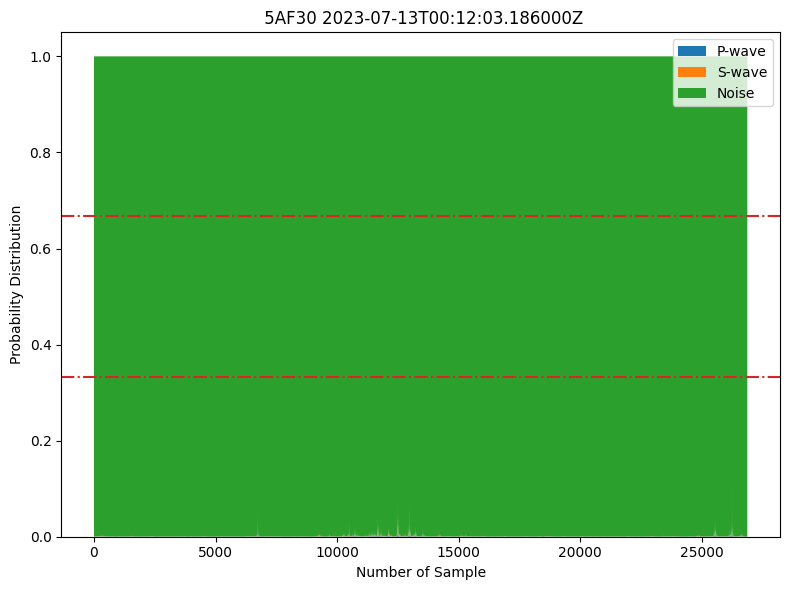

In [40]:
file_5AF30_test_1 = datadir + '/5AF30.TW..HLX.2023.07.13.00.12.03.sac'
file_5AF30_test_2 = datadir + '/5AF30.TW..HLY.2023.07.13.00.12.03.sac'
file_5AF30_test_3 = datadir + '/5AF30.TW..HLZ.2023.07.13.00.12.03.sac'
test_5AF30_test = read(file_5AF30_test_1) + read(file_5AF30_test_2) + read(file_5AF30_test_3)
stream_prep(test_5AF30_test, label = '5AF30_test_1')

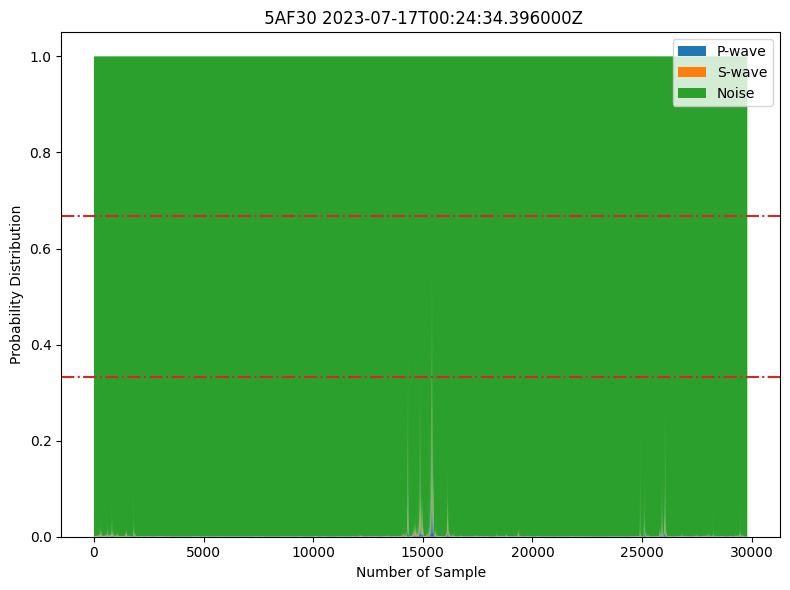

In [41]:
file_5AF30_test_2_1 = datadir + '/5AF30.TW..HLX.2023.07.17.00.24.34.sac'
file_5AF30_test_2_2 = datadir + '/5AF30.TW..HLY.2023.07.17.00.24.34.sac'
file_5AF30_test_2_3 = datadir + '/5AF30.TW..HLZ.2023.07.17.00.24.34.sac'
test_5AF30_test_2 = read(file_5AF30_test_2_1) + read(file_5AF30_test_2_2) + read(file_5AF30_test_2_3)
stream_prep(test_5AF30_test_2, label = '5AF30_test_2')